# Cyberattack Classification Using Deep Learning

## Table of Contents

1. **Introduction**  
2. **Dataset Description**  
3. **Problem Statement**  
4. **Data Preprocessing**  
   - Handling Outliers  
   - Encoding Categorical Features  
   - Standardization  
   - Feature Selection  
5. **Model Architecture**  
6. **Training and Evaluation**  
7. **Results**  
8. **Conclusions**  
9. **References**


## 1. Introduction

Cybersecurity is a critical area in today's connected world. Identifying and classifying cyberattacks using deep learning can provide a robust solution to mitigate threats efficiently. This project focuses on using the **UNSW-NB15** dataset to build a deep learning model for multi-class classification of cyberattacks.

---

## 2. Dataset Description

The UNSW-NB15 dataset contains a diverse range of network attack data. It includes normal and nine types of attack categories:
- Fuzzers
- Analysis
- Backdoors
- DoS
- Exploits
- Generic
- Reconnaissance
- Shellcode
- Worms

Each instance includes 49 features and labels for attack categories.
- - -

# 3. Problem Statement and Data Analysis

## 3.1 Problem Statement
This project focuses on network intrusion detection using deep learning techniques. Our main objectives are:

- Develop a robust multi-class classification model for network traffic
- Address the class imbalance challenge in cybersecurity datasets
- Create an effective preprocessing pipeline for network traffic data
- Implement and evaluate a deep learning solution for real-time threat detection




## 3.2 Data Analysis

### 3.2.1 Dataset Overview
The dataset contains network traffic information with both normal and malicious activities. Key characteristics include:

- Multiple features capturing network behavior
- 10 distinct classes (Normal + 9 attack categories)
- Significant class imbalance (Normal traffic dominates)
- Mix of numerical and categorical features




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import kagglehub


c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("dhoogla/unswnb15")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


In [3]:
def load_dataset(path):
    df = pd.read_parquet(path)
    return df

### 3.2.2 Class Distribution
Analysis of attack categories shows:
- Normal traffic: ~90,000 instances
- Generic attacks: ~58,000 instances
- Exploits: ~44,000 instances
- Fuzzers: ~24,000 instances
- DoS: ~16,000 instances
- Reconnaissance: ~13,000 instances
- Analysis: ~2,000 instances
- Backdoor: ~2,000 instances
- Shellcode: ~1,500 instances
- Worms: ~130 instances

### 3.2.3 Feature Analysis
The dataset includes various types of features:
- Network flow metrics (duration, packet counts)
- Protocol information
- Service types
- Connection states
- Binary indicators

In [4]:
class DataAnalysis:
    def __init__(self, df):
        self.df = df

    def analyze_dataset(self):
        print("\nDataset Overview:\n")
        print(self.df.info())

        print("\nFirst 5 Rows:\n")
        print(self.df.head())

        numerical_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns

        self._print_numerical_stats(numerical_cols)
        self._print_categorical_stats(categorical_cols)
        self._check_missing_values()
        self._analyze_class_distribution()
        self._plot_correlation_matrix(numerical_cols)
        self._plot_attack_category_distribution()
        self._plot_numerical_distributions(numerical_cols)
        self._plot_categorical_distributions(categorical_cols)
        self._analyze_feature_importance(numerical_cols, categorical_cols)

    def _print_numerical_stats(self, numerical_cols):
        print("\nNumerical Columns Statistics:\n")
        print(self.df[numerical_cols].describe())

    def _print_categorical_stats(self, categorical_cols):
        print("\nCategorical Columns Value Counts:\n")
        for col in categorical_cols:
            print(f"\n{col} value counts:")
            print(self.df[col].value_counts().head())

    def _check_missing_values(self):
        print("\nMissing Values:\n")
        print(self.df.isnull().sum())

    def _analyze_class_distribution(self):
        print("\nClass Distribution:\n")
        if 'attack_cat' in self.df.columns:
            print(self.df['attack_cat'].value_counts())

    def _plot_correlation_matrix(self, numerical_cols):
        if len(numerical_cols) > 0:
            print("\nCorrelation Matrix for Numerical Features:\n")
            correlation_matrix = self.df[numerical_cols].corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
            plt.title("Correlation Matrix - Numerical Features")
            plt.tight_layout()
            plt.show()

    def _plot_attack_category_distribution(self):
        if 'attack_cat' in self.df.columns:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=self.df, x='attack_cat')
            plt.title("Attack Category Distribution")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    def _plot_numerical_distributions(self, numerical_cols):
        if len(numerical_cols) > 0:
            selected_num_cols = numerical_cols[:5]
            plt.figure(figsize=(12, 4 * len(selected_num_cols)))
            for i, col in enumerate(selected_num_cols, 1):
                plt.subplot(len(selected_num_cols), 1, i)
                sns.histplot(data=self.df, x=col, hue='attack_cat', multiple="stack")
                plt.title(f"Distribution of {col}")
                plt.tight_layout()
            plt.show()

    def _plot_categorical_distributions(self, categorical_cols):
        if len(categorical_cols) > 0:
            selected_cat_cols = [col for col in categorical_cols if col != 'attack_cat'][:3]
            plt.figure(figsize=(12, 4 * len(selected_cat_cols)))
            for i, col in enumerate(selected_cat_cols, 1):
                plt.subplot(len(selected_cat_cols), 1, i)
                self.df[col].value_counts().plot(kind='bar')
                plt.title(f"Distribution of {col}")
                plt.xticks(rotation=45)
                plt.tight_layout()
            plt.show()

    def _analyze_feature_importance(self, numerical_cols, categorical_cols):
        print("\nCalculating Feature Importance...\n")
        if 'attack_cat' in self.df.columns and 'label' in self.df.columns:
            X = self.df.drop(['attack_cat', 'label'], axis=1)
            y = self.df['attack_cat']

            X = pd.get_dummies(X, columns=[col for col in categorical_cols if col not in ['attack_cat', 'label']])

            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)

            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': rf.feature_importances_
            }).sort_values('importance', ascending=False)

            print("Top 10 Most Important Features:")
            print(feature_importance.head(10))

            plt.figure(figsize=(12, 10))
            sns.barplot(data=feature_importance.head(30), x='importance', y='feature')
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()



Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  category
 2   service            257673 non-null  category
 3   state              257673 non-null  category
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt             257673 non-null  float32 
 15  sjit          

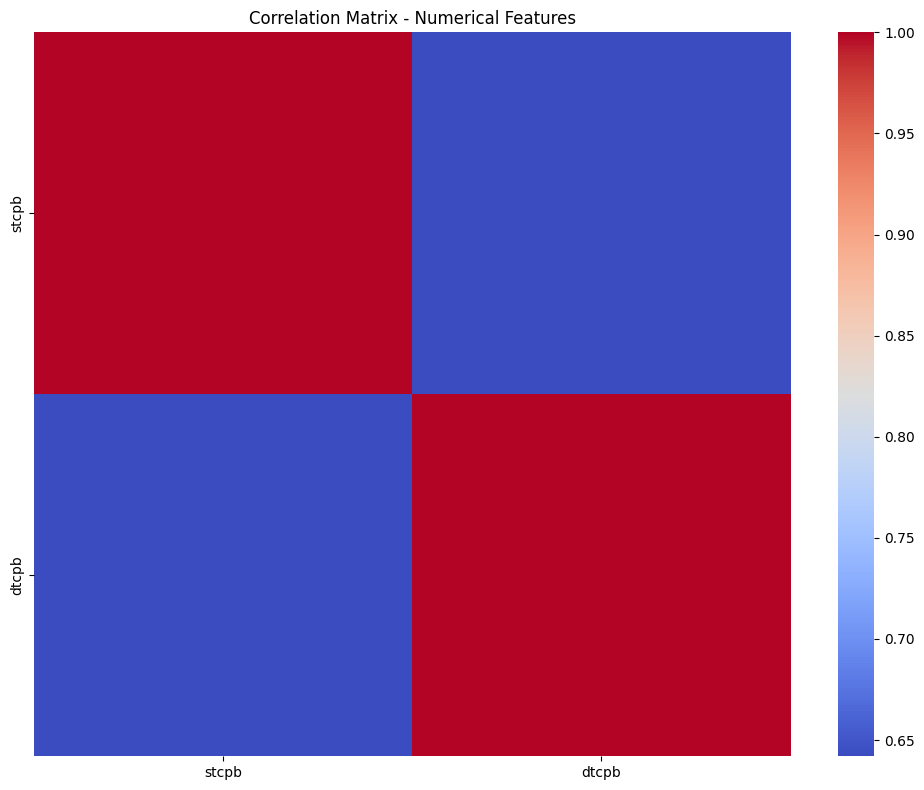

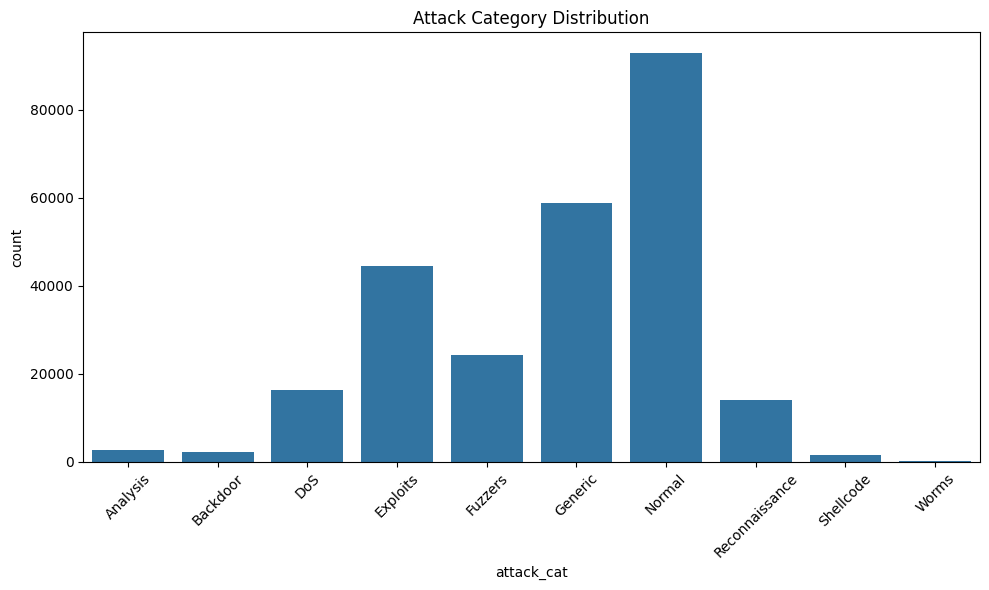

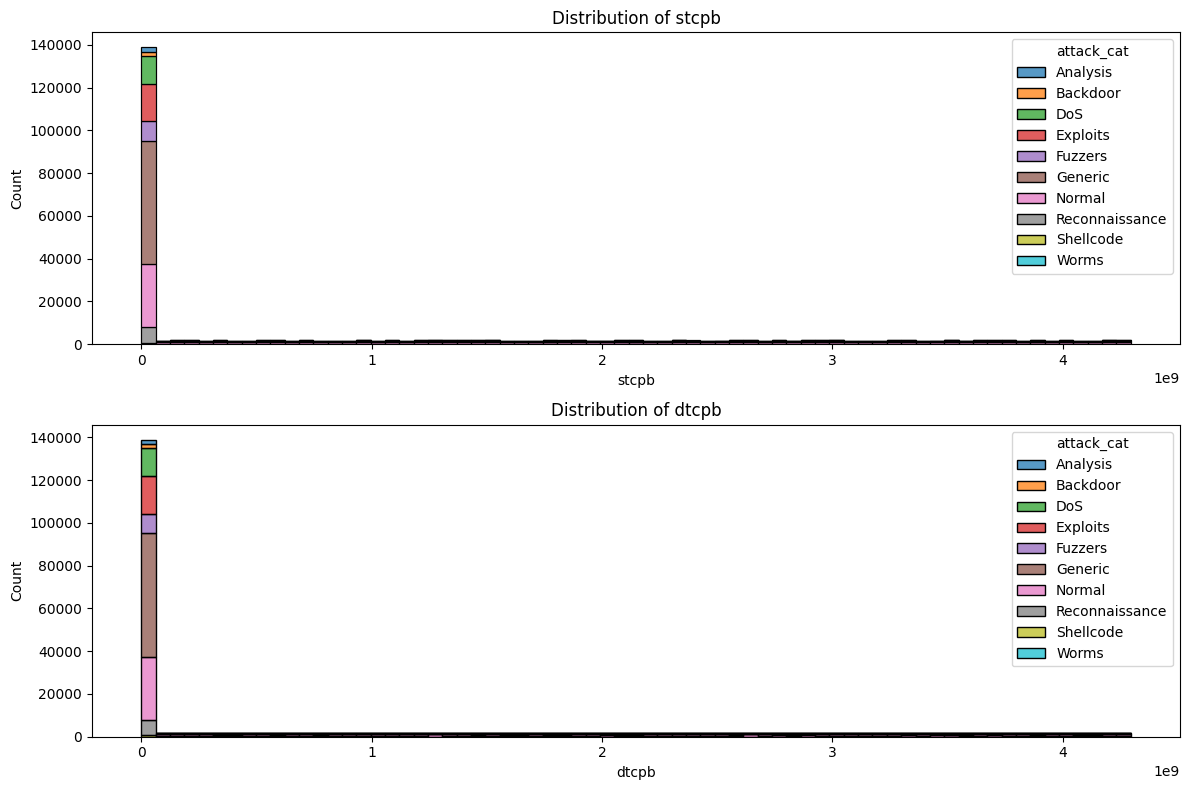

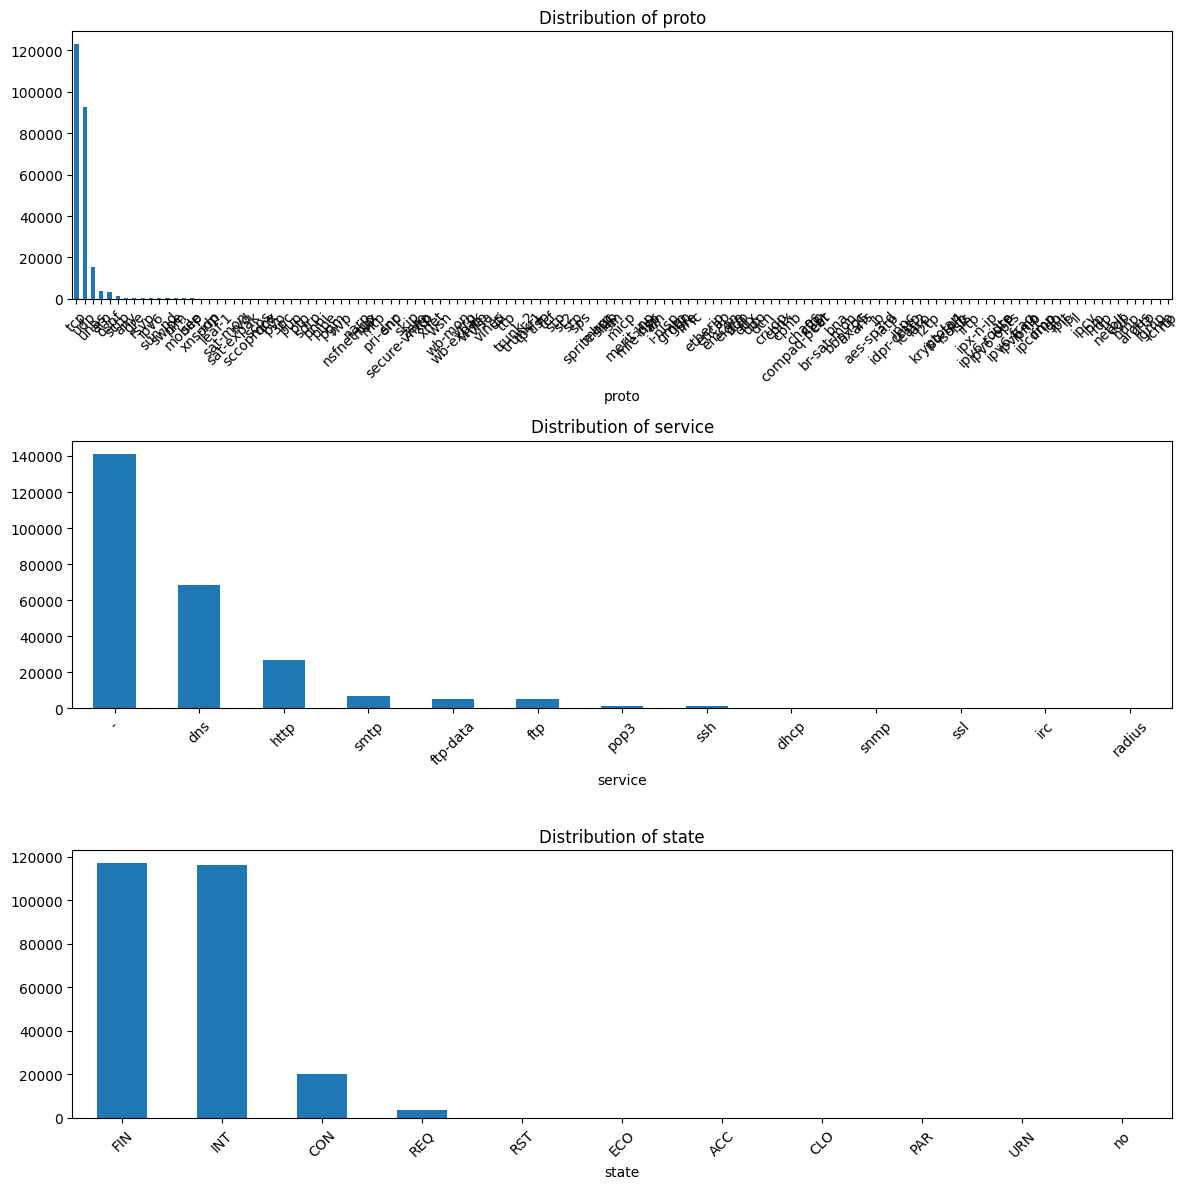


Calculating Feature Importance...

Top 10 Most Important Features:
              feature  importance
3              sbytes    0.091843
21              smean    0.074664
6               sload    0.058963
26   ct_dst_sport_ltm    0.054064
164         service_-    0.050591
166       service_dns    0.043754
25   ct_src_dport_ltm    0.042990
20             ackdat    0.038407
5                rate    0.038265
7               dload    0.037141


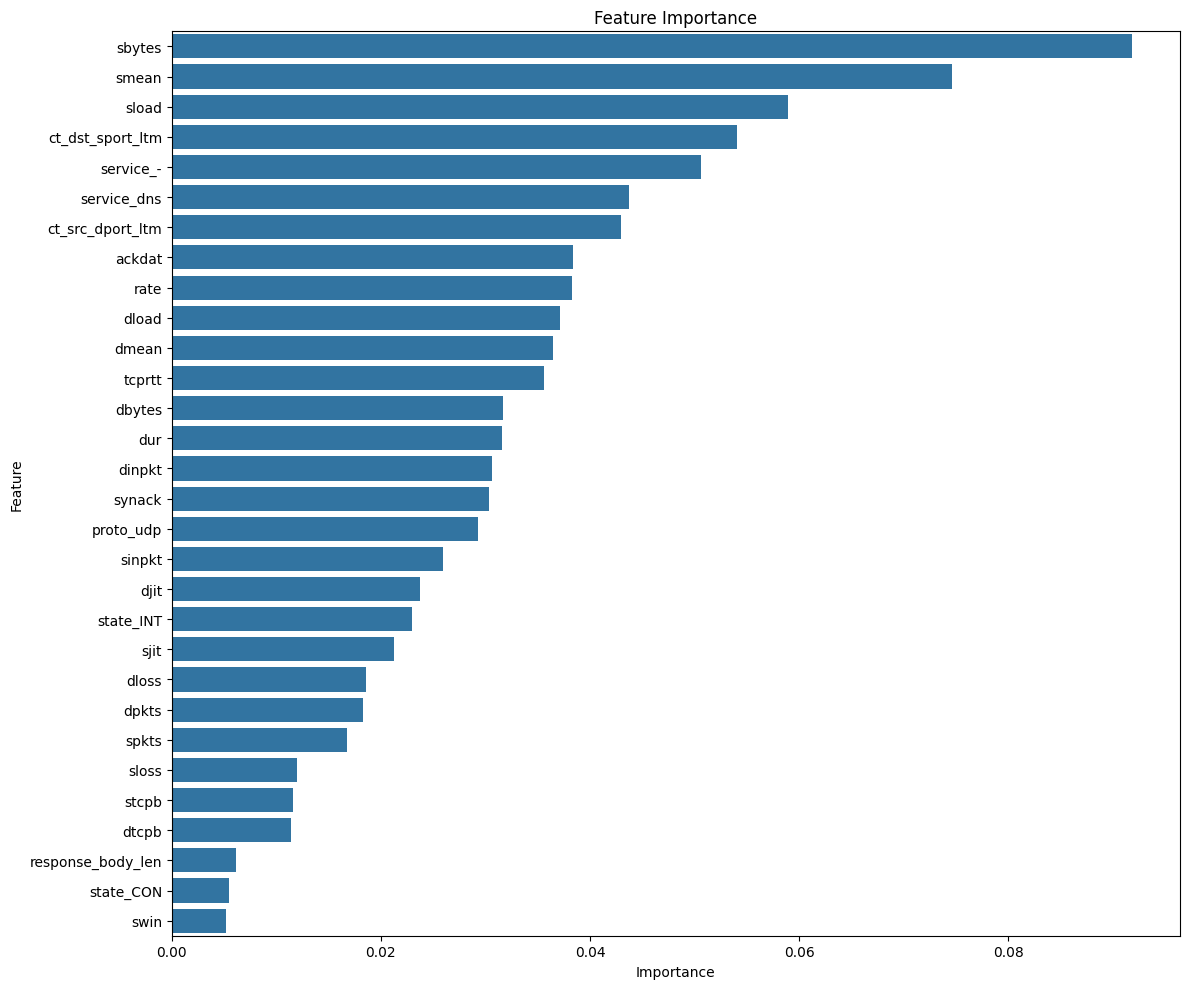

In [5]:
dataset = load_dataset(path)
data_analysis = DataAnalysis(df=dataset)
data_analysis.analyze_dataset()

# 4. Data Preprocessing

## 4.1 Handling Outliers
Our outlier handling strategy involves:
- Using Interquartile Range (IQR) method with 3×IQR threshold
- Applying outlier clipping to key numerical features:
  - Duration (`dur`)
  - Source packets (`spkts`)
  - Destination packets (`dpkts`)
  - Source loss (`sloss`)
  - Destination loss (`dloss`)
- Preserving data points by clipping rather than removal

## 4.2 Encoding Categorical Features
Categorical features are processed using multiple encoding strategies:

### 4.2.1 Protocol Features
- One-hot encoding for 'proto' column
- Valid protocols: tcp, udp, arp, ospf, igmp, icmp, rtp
- Rare protocols grouped into 'other' category

### 4.2.2 Service and State Features
- Label encoding applied
- Consistent encoding maintained between train and test sets
- Preservation of ordinal relationships where present

### 4.2.3 Binary Features
- Standardization of boolean values (True/False → 1/0)
- Clipping of binary features to ensure [0,1] range

## 4.3 Standardization
Numerical feature standardization process:
- Application of StandardScaler
- Mean centering (μ = 0)
- Unit variance scaling (σ = 1)
- Consistent scaling between train and test sets

## 4.4 Feature Selection and Data Balance

### 4.4.1 Feature Selection
- Removal of constant features using VarianceThreshold
- Elimination of redundant columns:
  - Source window size (`swin`)
  - TCP base sequence numbers (`stcpb`, `dtcpb`)
  - Destination window size (`dwin`)

### 4.4.2 Class Imbalance Handling
- Implementation of hybrid resampling approach:
  - Undersampling majority class (Normal)
  - SMOTE for minority classes
  - Preservation of class relationships
- Balanced training set creation while maintaining data integrity

This preprocessing pipeline ensures our data is optimally prepared for deep learning model training while preserving important relationships and addressing key challenges in network intrusion detection.

In [6]:
class Preprocess:
    def __init__(self, train_file_path, test_file_path):
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.lb_ub = {}
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.var_thresh = VarianceThreshold(threshold=0)
        
    def standardization(self, dataframe, col_name, is_test=False):
        """Standardize numerical columns"""
        if is_test:
            dataframe[col_name] = self.scaler.transform(dataframe[[col_name]])
        else:
            dataframe[col_name] = self.scaler.fit_transform(dataframe[[col_name]])

    def remove_outlier(self, data_frame, column_name, isTest=False, verbose=0):
        """Handle outliers using IQR method"""
        if isTest:
            data_frame.loc[data_frame[column_name] > self.lb_ub[column_name][1], column_name] = self.lb_ub[column_name][1]
            data_frame.loc[data_frame[column_name] < self.lb_ub[column_name][0], column_name] = self.lb_ub[column_name][0]
            return

        q1 = data_frame[column_name].quantile(0.25)
        q3 = data_frame[column_name].quantile(0.75)
        iqr = q3 - q1
        lb = q1 - 3 * iqr
        ub = q3 + 3 * iqr

        data_frame.loc[data_frame[column_name] > ub, column_name] = ub
        data_frame.loc[data_frame[column_name] < lb, column_name] = lb
        self.lb_ub[column_name] = (lb, ub)

        if verbose == 1:
            print(f"Outlier bounds for {column_name}: Lower={lb}, Upper={ub}")

    def encode_categorical(self, df, column, is_test=False):
        """Encode categorical variables with consistent mapping"""
        if column == 'proto':
            valid_protos = ['tcp', 'udp', 'arp', 'ospf', 'igmp', 'icmp', 'rtp']
            df[column] = df[column].apply(lambda x: x if x in valid_protos else 'other')
            return pd.get_dummies(df[column], prefix='proto', drop_first=False)
        else:
            if not is_test:
                self.label_encoders[column] = LabelEncoder()
                return self.label_encoders[column].fit_transform(df[column])
            return self.label_encoders[column].transform(df[column])

    def balance_dataset(self, X, y):
        """Apply SMOTE-Tomek links for dataset balancing"""
        # Define the resampling pipeline
        sampling_pipeline = ImbPipeline([
            ('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
            ('over', SMOTE(sampling_strategy='auto', random_state=42))
        ])
        
        # Apply the resampling
        X_resampled, y_resampled = sampling_pipeline.fit_resample(X, y)
        return X_resampled, y_resampled

    def train_set_preprocess(self):
        """Preprocess training dataset"""
        # Outlier handling
        numerical_cols = ['dur', 'spkts', 'dpkts', 'sloss', 'dloss']
        for col in numerical_cols:
            self.remove_outlier(self.train_df, col)

        # Max-value clipping
        cols_maxvals = {'spkts': 1.2, 'sloss': 1.2, 'dloss': 1.2}
        for col, multiplier in cols_maxvals.items():
            max_val = self.train_df[col].max()
            self.train_df.loc[self.train_df[col] > max_val, col] = max_val * multiplier

        # Binary features handling
        binary_cols = ['is_ftp_login', 'ct_ftp_cmd']
        for col in binary_cols:
            self.train_df.loc[self.train_df[col] > 1, col] = 1

        # Categorical encoding
        categorical_cols = ['proto', 'service', 'state']
        encoded_cats = {}
        for col in categorical_cols:
            if col == 'proto':
                encoded_cats[col] = self.encode_categorical(self.train_df, col)
            else:
                self.train_df[col] = self.encode_categorical(self.train_df, col)

        # Add encoded protocol columns
        for col in encoded_cats['proto'].columns:
            self.train_df[col] = encoded_cats['proto'][col]
        
        # Boolean values
        self.train_df.replace({True: 0, False: 1}, inplace=True)

        # Prepare features and target
        self.X_train = self.train_df.drop(['proto', 'attack_cat', 'label'], axis=1)
        self.y_train = self.train_df['attack_cat']

        # Remove constant features
        self.X_train = pd.DataFrame(
            self.var_thresh.fit_transform(self.X_train),
            columns=self.X_train.columns[self.var_thresh.get_support()]
        )

        # Standardization
        self.X_train = pd.DataFrame(
            self.scaler.fit_transform(self.X_train),
            columns=self.X_train.columns
        )

        # Balance dataset
        self.X_train, self.y_train = self.balance_dataset(self.X_train, self.y_train)
        
        return self.X_train, self.y_train

    def test_set_preprocess(self):
        """Preprocess test dataset"""
        # Apply same preprocessing steps as training
        numerical_cols = ['dur', 'spkts', 'dpkts', 'sloss', 'dloss']
        for col in numerical_cols:
            self.remove_outlier(self.test_df, col, isTest=True)

        # Max-value clipping
        cols_maxvals = {'spkts': 1.2, 'sloss': 1.2, 'dloss': 1.2}
        for col, multiplier in cols_maxvals.items():
            max_val = self.train_df[col].max()
            self.test_df.loc[self.test_df[col] > max_val, col] = max_val * multiplier

        # Binary features
        binary_cols = ['is_ftp_login', 'ct_ftp_cmd']
        for col in binary_cols:
            self.test_df.loc[self.test_df[col] > 1, col] = 1

        # Drop columns
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin']
        self.test_df.drop(columns=columns_to_drop, inplace=True)

        # Categorical encoding
        categorical_cols = ['proto', 'service', 'state']
        encoded_cats = {}
        for col in categorical_cols:
            if col == 'proto':
                encoded_cats[col] = self.encode_categorical(self.test_df, col, is_test=True)
            else:
                self.test_df[col] = self.encode_categorical(self.test_df, col, is_test=True)

        # Add encoded protocol columns
        for col in encoded_cats['proto'].columns:
            self.test_df[col] = encoded_cats['proto'][col]

        # Boolean values
        self.test_df.replace({True: 0, False: 1}, inplace=True)

        # Prepare features and target
        self.X_test = self.test_df.drop(['proto', 'attack_cat', 'label'], axis=1)
        self.y_test = self.test_df['attack_cat']

        # Remove constant features using same features as training
        self.X_test = self.X_test.loc[:, self.var_thresh.get_support()]

        # Standardization using fitted scaler
        self.X_test = pd.DataFrame(
            self.scaler.transform(self.X_test),
            columns=self.X_test.columns
        )

        return self.X_test, self.y_test

In [7]:
preprocessor = Preprocess(train_file_path=f"{path}/UNSW_NB15_training-set.parquet", 
                          test_file_path=f"{path}/UNSW_NB15_testing-set.parquet")

## 5. Model Architecture


## 6. Training and Evaluation

The dataset was split into training and test sets. The model was trained using the Adam optimizer with categorical cross-entropy loss. Evaluation metrics included accuracy, precision, recall, and F1-score.


## 7. Results

The final model achieved:
- **Accuracy**: [Insert Value]
- **Precision**: [Insert Value]
- **Recall**: [Insert Value]
- **F1-Score**: [Insert Value]

Confusion matrices and classification reports provide detailed insights into the model's performance.



## 8. Conclusions

The project demonstrated that deep learning models could classify network attacks effectively. Future work could involve:
- Exploring other machine learning algorithms.
- Implementing the solution in real-time systems.
- Evaluating the model on other datasets.


## 9. References

- [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)
- Notebook inspiration and preprocessing techniques were adapted from: [Soumit's Kaggle Notebook](https://www.kaggle.com/code/soumit1803063/unswnb15-preprocess)
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
